In [29]:
# Copyright 2023 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Imports

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from nuclease_design import amino_acids
from nuclease_design import constants
from nuclease_design import plotting
from nuclease_design import utils


# Load data

In [31]:
DATA_DIR = constants.DATA_DIR

In [32]:
df = utils.load_all_data(DATA_DIR)
expand_df = utils.expand_sublibraries(df)

In [33]:
landscape_df = utils.load_landscape(DATA_DIR)

In [34]:
def get_landscape_up_to_generation(landscape_df, generations):
  new_df = landscape_df[
      landscape_df['generations'].apply(
          lambda x: any(generation in x for generation in generations)
      )
  ]
  return new_df


def remove_controls(df, non_control_sublibrary_names):
  new_df = df[
      df['sublibrary_names'].apply(
          lambda x: any(
              sublibrary_name in x
              for sublibrary_name in non_control_sublibrary_names
          )
      )
  ]
  print('removed: ', df.shape[0] - new_df.shape[0])
  return new_df

In [35]:
non_controls_g3 = [
    'g3_prosar_high_screen_low',
    'g3_prosar_high_screen_high',
    'g3_prosar_low_screen_high',
    'g3_prosar_low_screen_low',
    'g3_prosar_low_unscreened',
    'g3_mbo_dnn_exploit',
    'g3_mbo_dnn_explore',
    'g3_unmatched',
]

non_controls_g4 = [
    'g4_other',
    'g4_unmatched',
    'g4_mbo_dnn',
    'g4_mbo_linear',
    'g4_sample_and_screen_dnn',
    'g4_sample_and_screen_linear',
    'g4_sample_unscreened',
]

In [36]:
def add_activity_level_columns(landscape_df):
  df = landscape_df.copy()
  for ref, activity_level in zip(['neg_control', 'wt', 'a73r'], ['activity_greater_than_0', 'activity_greater_than_WT',  'activity_greater_than_A73R']):
    df[f'activity_greater_than_{ref}'] = df['activity_level'] == activity_level
  return df

In [37]:
landscape_df = add_activity_level_columns(landscape_df)

In [38]:
up_to_g1_df = get_landscape_up_to_generation(landscape_df, {'g1'}).copy()
g2_redux_df = expand_df[expand_df['sublibrary_name'] == 'prosar+screen_g2_redux']

up_to_g2_df = get_landscape_up_to_generation(landscape_df, {'g1', 'g2'}).copy()
non_controls_g3_df = remove_controls(df[df['generation'] == 'g3'], non_controls_g3)

up_to_g3_df = get_landscape_up_to_generation(landscape_df, {'g1', 'g2', 'g3'}).copy()
non_controls_g4_df = remove_controls(df[df['generation'] == 'g4'], non_controls_g4)

removed:  3764
removed:  4467


In [39]:
name_to_plot_kwargs = {
    'G1': {'train_df': up_to_g1_df, 'design_df': g2_redux_df, 'activity_level': 'wt'},
    'G2': {'train_df': up_to_g2_df, 'design_df': non_controls_g3_df, 'activity_level': 'wt'},
    'G3': {'train_df': up_to_g3_df, 'design_df': non_controls_g4_df, 'activity_level': 'wt'},
}

In [40]:
up_to_g2_df.columns

Index(['mutations', 'num_mutations', 'sublibrary_names', 'generations',
       'activity_level', 'is_functional', 'sequence',
       'activity_greater_than_neg_control', 'activity_greater_than_wt',
       'activity_greater_than_a73r'],
      dtype='object')

In [41]:
up_to_g1_df['activity_level'].value_counts()

activity_level
non-functional              8463
activity_greater_than_0      875
activity_greater_than_WT     103
Name: count, dtype: int64

In [42]:
def make_hits_histplot(train_df, design_df, activity_level, ax=None):
  train_df = train_df.copy()
  design_df = design_df.copy()
  if activity_level not in {'neg_control', 'wt', 'a73r'}:
    raise ValueError(f'{activity_level} not in [neg_control, wt, a73r]')

  train_hits_df = train_df[
      train_df[f'activity_greater_than_{activity_level}']
  ].copy()
  train_hits_df['set'] = 'training set hits'
  design_hits_df = design_df[
      design_df[f'activity_greater_than_{activity_level}']
  ].copy()
  design_hits_df['set'] = 'designed hits'
  plotdf = pd.concat([train_hits_df, design_hits_df], ignore_index=True)
  ax.legend(bbox_to_anchor=(1.05, 1))
  sns.histplot(
      data=plotdf,
      x='num_mutations',
      hue='set',
      multiple='layer',
      discrete=True,
      ax=ax,
  )

In [43]:
# COLOR_A = '#d3eaf3'  # light blue
COLOR_A = '#9FA0C3'
COLOR_B = '#45f0ac'  # turquoise
sns.set_palette([COLOR_A, COLOR_B])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Number of mutations')

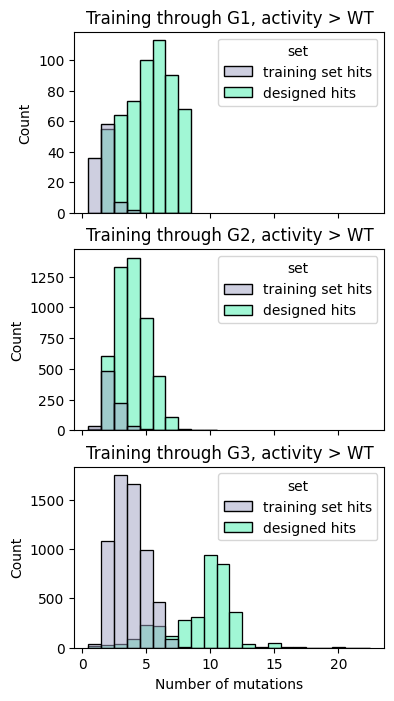

In [50]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=(4, 8))
for i, (name, kwargs) in enumerate(name_to_plot_kwargs.items()):
  ax = axs[i]
  make_hits_histplot(ax=ax, **kwargs)
  activity_level = kwargs['activity_level']
  str_activity_level = activity_level.upper()
  ax.set_title(f'Training through {name}, activity > {str_activity_level}')
plt.xlabel('Number of mutations')

# Novelty analysis

In [45]:
def get_novel_mutations(train_df, design_df, activity_level):
  activity_column = f'activity_greater_than_{activity_level}'
  unique_design_mutations = (
      design_df[design_df[activity_column]].mutations.explode().unique()
  )
  unique_train_mutations = (
      train_df[train_df[activity_column]].mutations.explode().unique()
  )
  return pd.Series(unique_design_mutations)[
      ~pd.Series(unique_design_mutations).isin(unique_train_mutations)
  ].values

In [46]:
def get_unique_mutations(df, activity_level):
  df = df[df['num_mutations'] > 0].copy()
  activity_column = f'activity_greater_than_{activity_level}'
  return df[df[activity_column]].mutations.explode().unique()

In [47]:
def make_mutation_heatmap_comparison(
    mutations_a,
    mutations_b,
    color_a,
    color_b,
    inclusive_one_indexed_position_start,
    exclusive_one_indexed_position_end,
    ax,
    parent_sequence=constants.FULL_REFERENCE_SEQ,
):
  aa_sorted = sorted(
      amino_acids.AA, key=amino_acids.AA_TO_ISOELECTRIC_POINT.get, reverse=True
  )
  aa_to_index = {aa: i for i, aa in enumerate(aa_sorted)}

  positions = list(
      range(
          inclusive_one_indexed_position_start,
          exclusive_one_indexed_position_end,
      )
  )

  val_a = 1
  val_b = 2
  # parent_val = 3
  counts = np.zeros(shape=(max(positions) + 1, len(amino_acids.AA)))
  for mutations, val in zip((mutations_a, mutations_b), (val_a, val_b)):
    plotting._add_mutations_to_count_matrix(counts, mutations, val, aa_to_index)

  parent_plot_indexes = []
  for one_indexed_position in range(
      inclusive_one_indexed_position_start, exclusive_one_indexed_position_end
  ):
    parent_aa = parent_sequence[one_indexed_position - 1]
    parent_plot_indexes.append((one_indexed_position, aa_to_index[parent_aa]))

  df = pd.DataFrame(counts.T, index=aa_to_index.keys())

  light_color = sns.light_palette(color_a)[0]
  cmap = sns.color_palette(
      [light_color, color_a, color_b], as_cmap=True
  )

  sns.heatmap(
      data=df,
      ax=ax,
      xticklabels=5,
      yticklabels=True,
      linewidths=0.1,
      cbar=False,
      cmap=cmap,
  )
  ax.set(xlabel='', ylabel='')

  xs = [index[0] + 0.5 for index in parent_plot_indexes]
  ys = [index[1] + 0.5 for index in parent_plot_indexes]
  ax.plot(xs, ys, marker='.', color=plotting.WT_COLOR, linestyle='None')

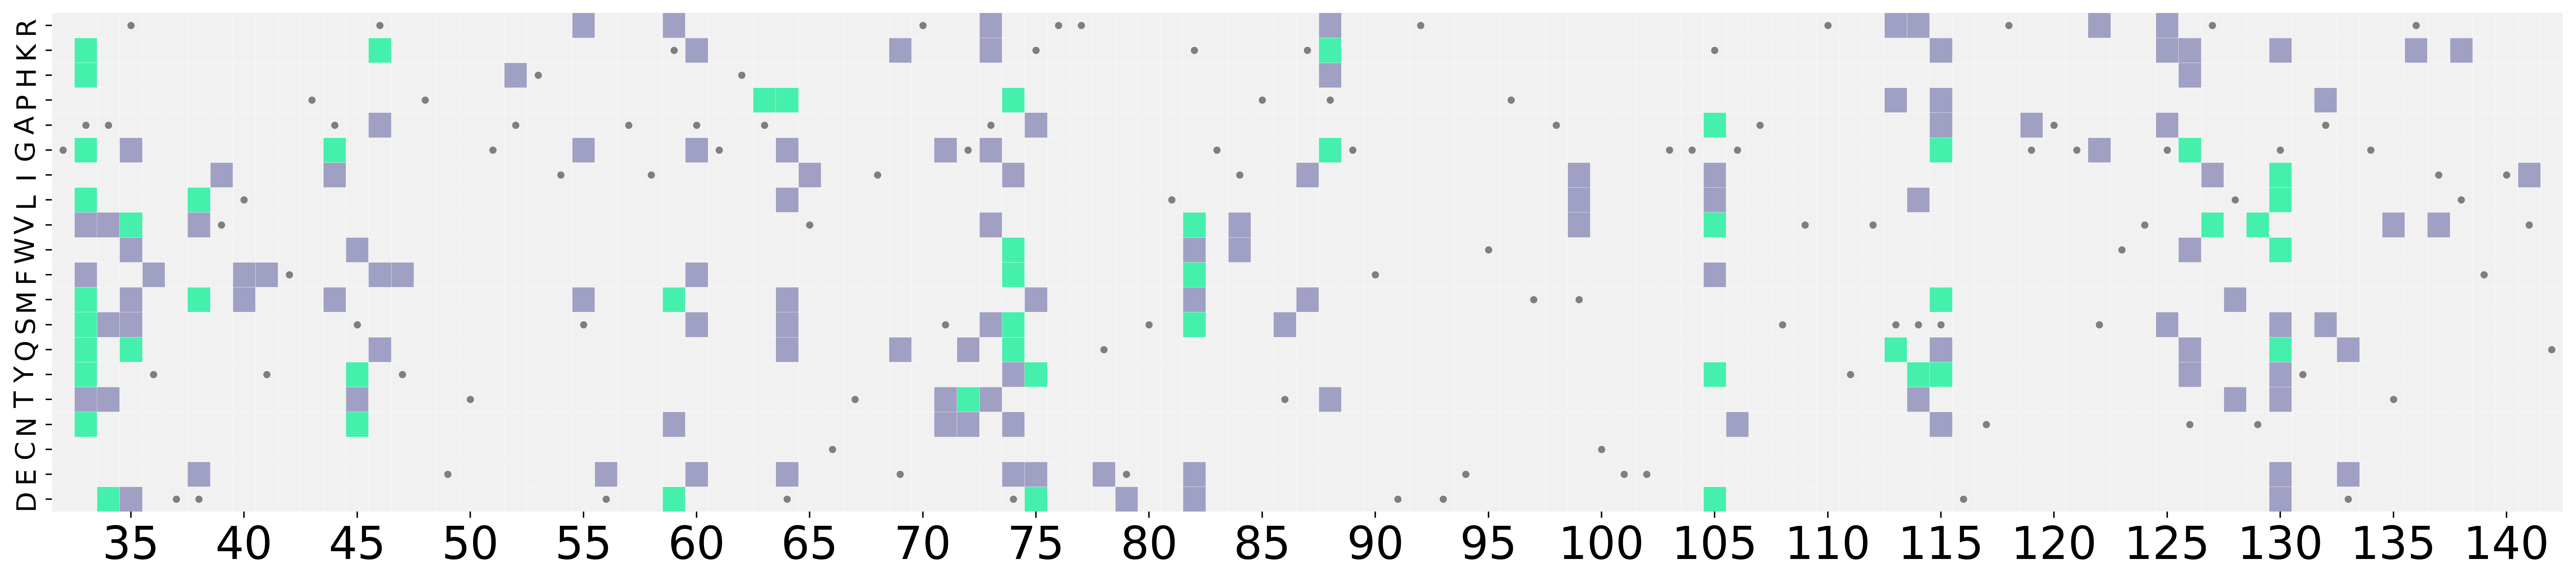

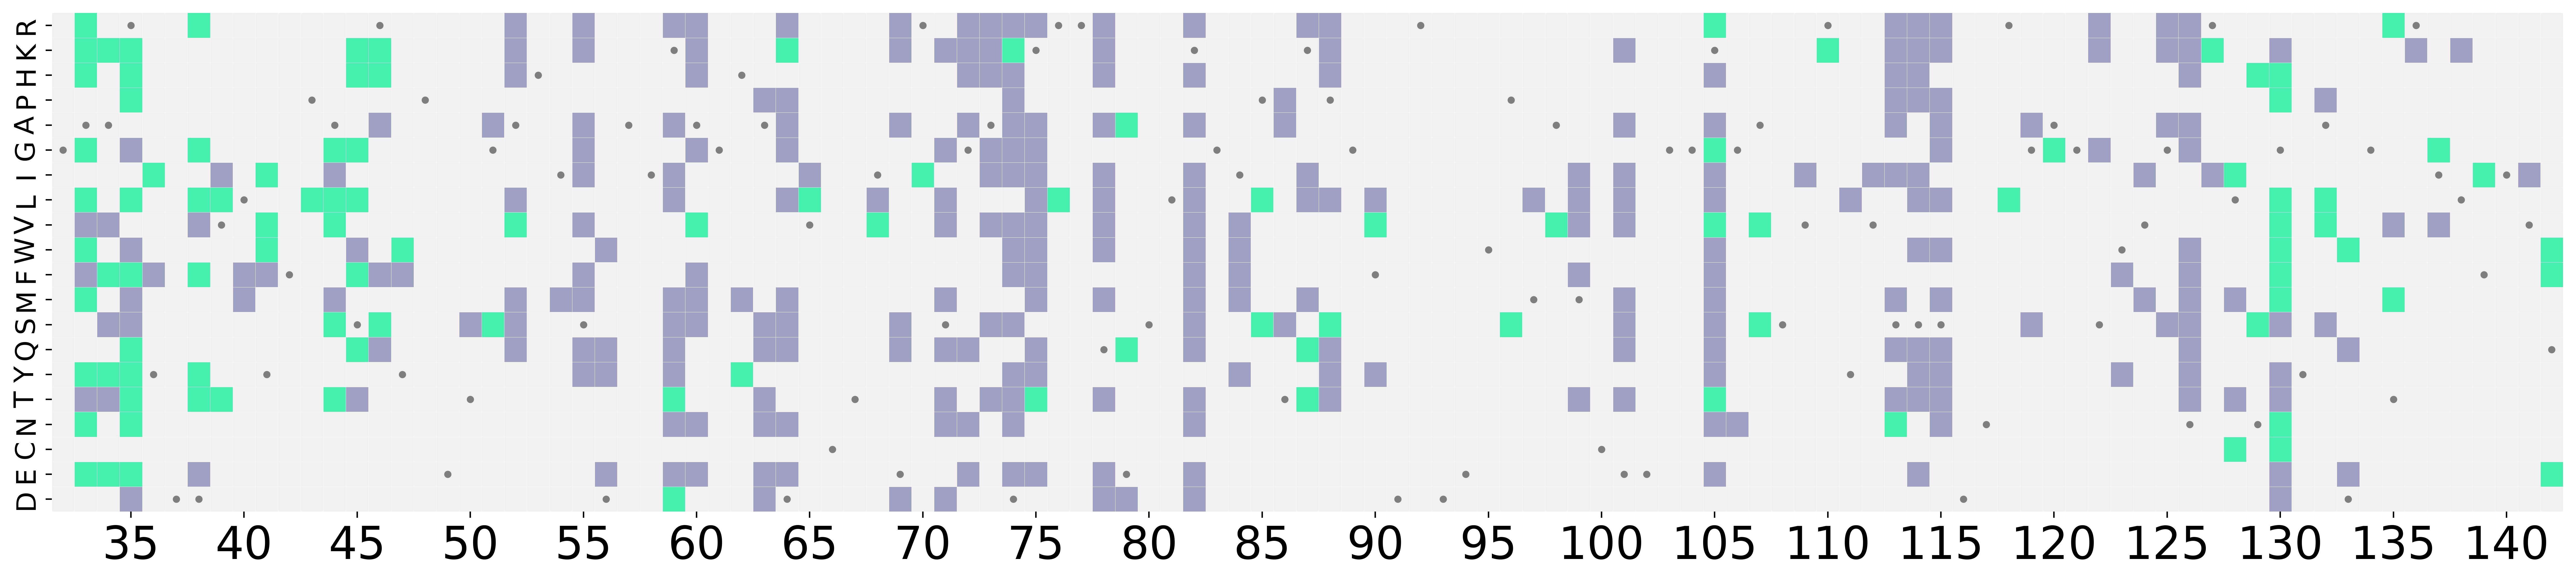

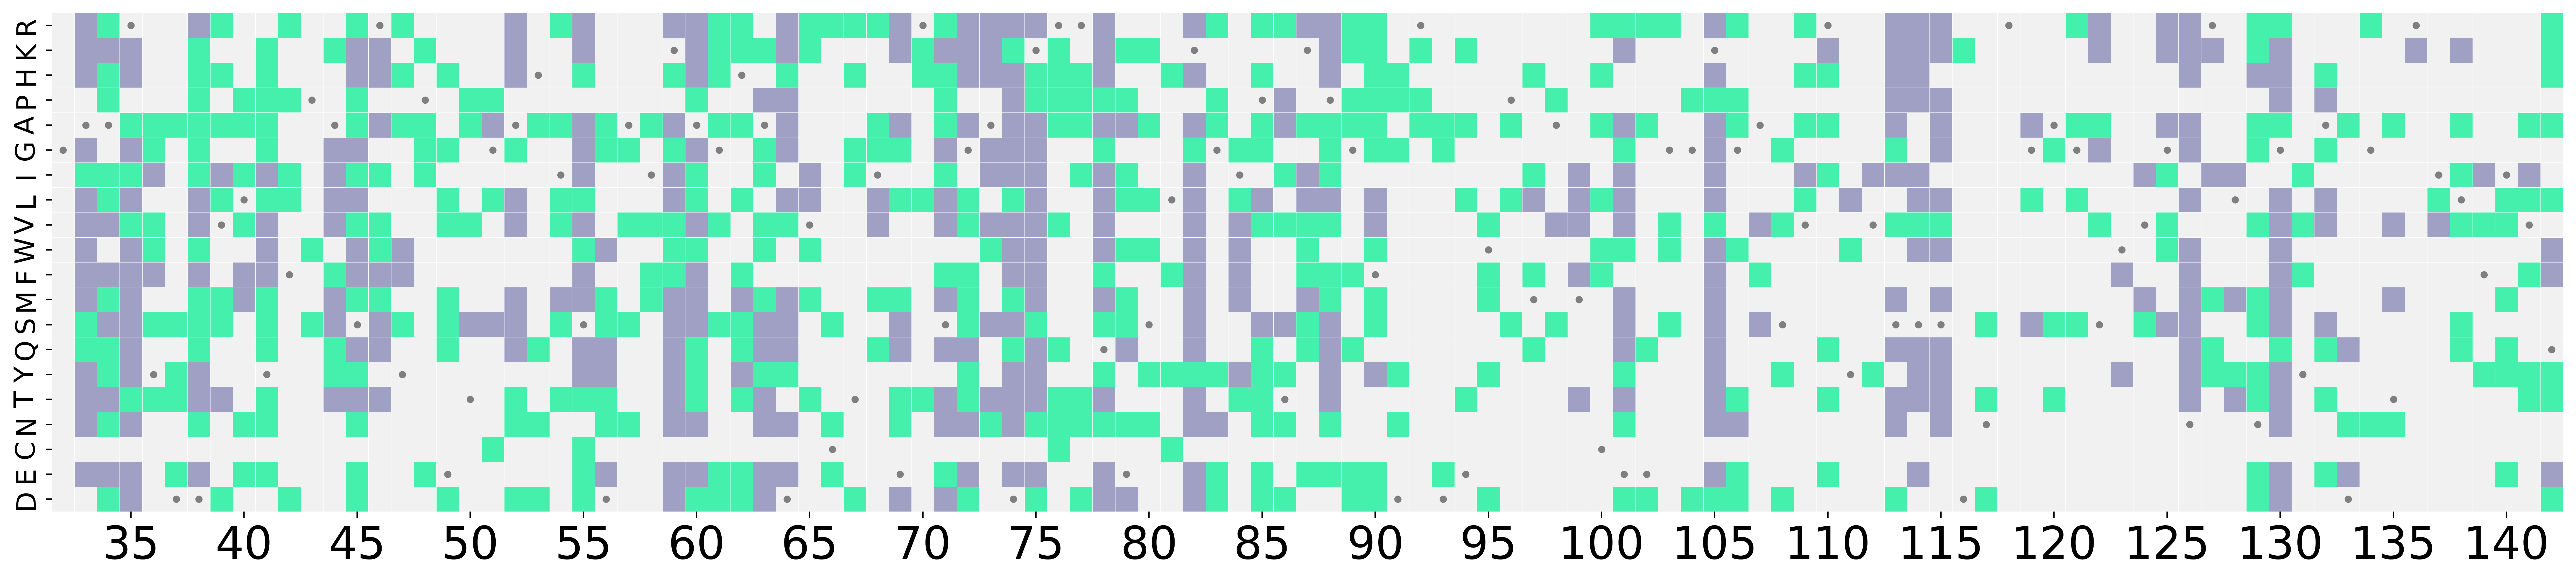

In [48]:
for i, (name, kwargs) in enumerate(name_to_plot_kwargs.items()):

  fig, ax = plt.subplots(figsize=(25, 5), dpi=500)
  train_df = kwargs['train_df']
  train_df = train_df[train_df['num_mutations'] > 0]

  mutations_a = get_unique_mutations(
      train_df, activity_level=kwargs['activity_level']
  )
  color_a = sns.color_palette()[0]
  mutations_b = get_novel_mutations(**kwargs)
  color_b = sns.color_palette()[1]

  make_mutation_heatmap_comparison(
      mutations_a,
      mutations_b,
      color_a,
      color_b,
      inclusive_one_indexed_position_start=constants.G4_VARIABLE_REGION_START,
      exclusive_one_indexed_position_end=constants.G4_VARIABLE_REGION_END,
      ax=ax,
  )
  ax.yaxis.set_tick_params(labelsize=15)
  ax.xaxis.set_tick_params(labelsize=25)
  plt.xlim(left=constants.G4_VARIABLE_REGION_START, right=constants.G4_VARIABLE_REGION_END)